# Risk Factors
#### RMorris 14/05/2019
The aim of this notebook is to characterise the STEMI cohort in the 3-month extract of the EMR. We will extract risk factors from primary sources in the EMR (e.g., medical notes, pathology results, observations, etc) and compare the results with secondary sources (e.g., ICD10 codes) and previous literature. For example, [Khan *et al* 2018](https://onlinelibrary.wiley.com/doi/full/10.5694/mja17.01109#mja2tb01109118-box-0001) provides contemporaneous data on an Australian STEMI cohort in the CONCORDANCE registry. And [Vernon *et al* 2017](https://journals.sagepub.com/doi/full/10.1177/2047487317720287) also provides characteristsics for a NSLHD STEMI cohort. 

The various risk factors have been recorded on [confluence](https://ctdshub.atlassian.net/wiki/spaces/HEAL/pages/767492185/Characteristics+and+Risk+Factors+in+the+EMR), and the current list is:  
1. Diabetes (see other notebook)
2. Smoking
3. BMI
4. Hypertension (high blood pressure)
5. Hyperlipidemia (high cholesterol)
6. Family history of ischemic heart disease (to be done)
7. Past medical history of heart disease (to be done) 

Below is an example of the STEMI baseline characteristics according to ICD10 codes: 

|SPEED-EXTRACT  | Female | %Female | Male | %Male | Total | ICD10         | Female | %Female | Male | %Male | Total |
|---------------|--------|---------|------|-------|-------|---------------|--------|---------|------|-------|-------|
|Total number   |   26   |   25%   |  77  |  75%  |  103  |    "           |   ...   |   ...   |  ...  |  ...  |  ...  |
|Mean Age       |   77   |   ...   |  64  |  ...  |  67   | "       |   ...   |   ...   |  ...  |  ...  |  ...   |
|Diabetes       |   5    |   19%   |  8  |  10%  |  13%  | "       |   5    |   19%   |  14  |  18%  |  18%  |
|Hypertension   |   23    |   88%   |  66  |  86%  |  86%  | "   |   8    |   31%   |  13  |  17%  |  20%  |
|Hyperlipidemia |   19    |   73%    |   56  |   73%  |   73%  | " |   1    |   4%    |   6  |   8%  |   7%  |
|BMI            |
|  *Healthy*    |
|  *Overweight* |
|  *Obese*      |
|Smoking status |
|  *Current*    |
|  *Ex-smoker*  |
|  *Never*      |
 

#### Import data

In [1]:
library(tidyverse)
library(knitr)
library(kableExtra)
library(IRdisplay)
source("../src/extract_numeric.R")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘kableExtra’

The following object is masked from ‘package:dplyr’:

    group_rows



In [2]:
# Our list of facilities in Northern Sydney Local Health District
NSLHD <- c("Ryde", "Hornsby", "Royal North Shore", "Manly", "Mona Vale")

#### IMPORTING DATA ####
# We will import and ensure all column names are lower case

# import the STEMI episodes from the cardiology journey data
read_rds('../data/encounter_journey_3m_trop_acs.rds') %>%
  rename_all(tolower) %>%
  rename(Status = icd10stemi.status, Gender = gender, Age = age) %>%
  filter(Status %in% c("NSTEMI", "STEMI")) %>%
  mutate() %>%
  group_by(journey_key) %>%
  mutate(
    # A flag to select journeys treated in NSLHD facilities:
    nslhd = any(facility %in% NSLHD),
    # A flag to select journeys that were not waitlisted:
    waitlisted = any(enclass == "WaitListed"),
    # Remove APAC because it is not a hospital facility:
    facility = fct_recode(facility, NULL = "APAC"),
  ) %>%
  ungroup() %>%
  mutate(
    Facility = as.character(facility), # because factors are shit
    Status = ordered(Status, levels = c("STEMI", "NSTEMI")) # sometimes ok
  ) %>% 
  filter(!waitlisted, nslhd) %>%
  select(-waitlisted, -nslhd, -facility) -> nslhd_enctrs

# import the patient history
patient_history.rds <- read_rds('../data/patient_social_history.rds') %>%
  as_tibble() %>%
  rename_all(tolower)

# import the ED notes
notes_ED.rds <- read_rds('../data/notes_ED_3m.rds') %>%
  as_tibble() %>%
  rename_all(tolower)

# import the medications table
meds_spread.rds <- read_rds('../data/meds_spread.rds')
  as_tibble() %>%
  rename_all(tolower)

# import the form data
form_data.rds <- read_rds('../data/form_data.rds') %>%
  as_tibble() %>%
  rename_all(tolower)

# import the pathology results data
pathology_result.rds <- read_rds('../data/pathology.rds') %>%
  as_tibble() %>%
  rename_all(tolower)

# import the ICD10 codes
diagnosis_icd10.rds <- read_rds('../data/diagnosis_icd10.rds') %>%
  rename_all(tolower) %>% 
  select(encntr_key, d_present_on_admit_disp, display_identifier, source_string)

<0 x 0 matrix>

## Gender

In [3]:
nslhd_enctrs %>%
  filter(Status == "STEMI") %>%
  select(journey_key, Gender, Age) %>%
  distinct() %>%
  group_by(Gender) %>%
  summarise(
    `Total number` = n(),
  ) %>%
  bind_rows(summarise_all(
    ., list(~if(is.numeric(.)) sum(.) else "Total"))) %>%
  column_to_rownames("Gender") %>%
  t() %>%
  as.data.frame() %>%
  rownames_to_column("STEMI") %>%
  mutate(
    `%Female` = round(Female / Total*100),
    `%Male` = round(Male / Total*100)
  ) %>%
  select(1, Female, `%Female`, Male, `%Male`, Total) %>%
  kable() %>% as.character() %>% display_html()

STEMI,Female,%Female,Male,%Male,Total
Total number,26,25,77,75,103


The STEMI cohort is dominated by males (75%), which is similar to CONCORDANCE and Vernon *et al*. 

## Age

In [4]:
nslhd_enctrs %>%
  filter(Status == "STEMI") %>%
  select(journey_key, Gender, Age) %>%
  distinct() %>%
  add_row(Gender = "Total", Age = mean(.$Age, na.rm = TRUE)) %>%
  group_by(Gender) %>%
  summarise(
    `Mean Age` = round(mean(Age, na.rm = TRUE), 1),
  ) %>%
  column_to_rownames("Gender") %>%
  t() %>%
  as.data.frame() %>%
  rownames_to_column("STEMI") %>%
  kable() %>% as.character() %>% display_html()

STEMI,Female,Male,Total
Mean Age,77.3,64.2,67.5


Mean age of STEMI is 67.5 year old, which is slightly higher than CONCORDANCE and Vernon *et al* where the mean age was ~64 years old.

## Diabetes
Diabetes is defined as a HbA1c test result greater than 6.5 percent (see pathology table). However patients with well-managed diabetes might not be revealed by this definition.  

We will need to check:
1. ICD10 codes (`E11.9|E11.72|E11.22|E11.29`)
2. Prior medical history (ED notes)
3. Progress notes (for new cases)
4. Medications for insulin and antidiabetics
5. HbA1c test results (pathology)

### 1. ICD10 codes

In [5]:
join_icd10_diabetes <- function(stemi_input, icd10_input) {
    
  diagnosis <- icd10_input %>%
    select(encntr_key, d_present_on_admit_disp, 
           display_identifier, source_string)
    
    
  stemi_input %>%
    left_join(diagnosis, by = "encntr_key") %>% 
    group_by(journey_key) %>%
    mutate(
    # Define diabetes pre-existing or new conditions
    diabetes_icd10 = case_when(
      any(str_detect(source_string, "diabetes mellitus") & 
            d_present_on_admit_disp == "[1] Onset During Episode") ~ "New",
      any(str_detect(source_string, "diabetes mellitus"))          ~ "Present",
      all(is.na(source_string))                                    ~ "Missing",
      TRUE                                                         ~ "Absent"
      )
    ) %>% 
    select(-d_present_on_admit_disp, -display_identifier, -source_string) %>%
    distinct() %>%
    ungroup() -> out_df

  return(out_df)    
}

nslhd_enctrs %>%
  join_icd10_diabetes(diagnosis_icd10.rds) %>%
  select(Status, Gender, journey_key, diabetes_icd10) %>%
  distinct() -> nslhd_journeys_diabetes_icd10

In [28]:
nslhd_journeys_diabetes_icd10 %>%
  filter(Status == "STEMI") %>%
  mutate(diabetes = fct_relevel(diabetes_icd10, "Present")) %>%
  count(Gender, diabetes) %>%
  spread(diabetes, n, fill = 0) %>% 
  bind_rows(summarise_all(., list(~if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent + New),
    `%Present` = round(Present/Total*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent + New)),1)
  ) %>%
  rename(Diabetes = Gender) %>%
  kable(caption = "Source: ICD10") %>% 
  as.character() %>% display_html()

Diabetes,Present,Absent,New,Total,%Missing,%Present,%Error
Female,5,20,1,26,0,19.2,7.7
Male,14,63,0,77,0,18.2,4.4
Total,19,83,1,103,0,18.4,3.8


*Diabetes mellitus* prevalence is slighty less than **20 percent** in this STEMI cohort, according to the **ICD10 codes**. This is similar to CONCORDANCE but less than half of Vernon *et al* (46 percent). Vernon *et al* determined presence of risk factors by medical notes, which we also examine here.

### 2. ED notes

In [8]:
join_notes_diabetes <- function(stemi_input, notes_input) {
    
  notes_input %>%
    select(encntr_key, note_value) %>%
    as_tibble() -> notes_table
    
  source("../src/CLACK/R/CLACK.R")

  stemi_input %>%
    left_join(notes_table, by = "encntr_key") %>%
    group_by(journey_key) %>%
    mutate(noted = any(!is.na(note_value))) %>%
    ungroup() %>%
    Classify_Text("note_value", "../src/diabetes.json") %>%
    group_by(journey_key) %>%
    mutate(
      diabetes_noted = case_when(
        any(CLASSIFICATION == "high") ~ "Present",
        all(!noted)                   ~ "Missing",
        TRUE                          ~ "Absent"
        )
      ) %>%
    select(
      -noted, -note_value, -CLASSIFICATION, -CLASSIFICATION_REASON
      ) %>%
    ungroup() %>%
    distinct() -> out_df
    
  return(out_df)
}

nslhd_enctrs %>%
  join_notes_diabetes(notes_ED.rds) %>%
  select(Status, Gender, journey_key, diabetes_noted) %>%
  distinct() -> nslhd_journeys_diabetes_noted

In [27]:
nslhd_journeys_diabetes_noted %>%
  filter(Status == "STEMI") %>%
  mutate(diabetes = fct_relevel(diabetes_noted, "Present")) %>%
  count(Gender, diabetes) %>%
  spread(diabetes, n) %>%
  bind_rows(summarise_all(., list(~if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Diabetes = Gender) %>%
  kable(caption = "Source: ED notes") %>% 
  as.character() %>% display_html()

Diabetes,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,2,14,10,26,38.5,12.5,8.3
Male,5,44,28,77,36.4,10.2,4.3
Total,7,58,38,103,36.9,10.8,3.8


The prevalence of *diabetes mellitus* in **ED notes** is **~11 percent**; approximately half of that recorded in ICD10 and CONCORDANCE (~20%) and less than a quarter of Vernon *et al* (46%)

### 3. Progress notes
To be done

### 4. Medicines 

In [18]:
join_meds_diabetes <- function(stemi_input, medicine_input) {
    
  source("../src/journeyr.r")
   
  stemi_input %>%
    mark_journeys_with_discharge_meds(medicine_input) %>% # from journeyr.r
    mutate(has_meds = final_groups != "NULL") %>%         # from journeyr.r
    select(journey_key, has_meds) -> episodes_with_medicines
    
  medicine_input %>%
    filter(purrr::map_lgl(groups, ~any(stringr::str_detect(.x, "Insulin|diabetic")))) %>%
    select(encntr_key, medication_name) -> diabetes_medicines
    
  stemi_input %>%
    left_join(diabetes_medicines, by = c("encntr_key")) %>%
    left_join(episodes_with_medicines, by = c("journey_key")) %>%
    group_by(journey_key) %>%
    mutate(
      diabetes_meds = case_when(
        any(!is.na(medication_name)) ~ "Present",
        !has_meds ~ "Missing",
        TRUE ~ "Absent"
        )
      ) %>%
    select(-medication_name, -has_meds) %>%
    ungroup() %>%
    distinct() -> out_df
    
  return(out_df)
}

nslhd_enctrs %>%
  join_meds_diabetes(meds_spread.rds) %>%
  select(Status, Gender, journey_key, diabetes_meds) %>%
  distinct() -> nslhd_journeys_diabetes_meds

In [29]:
nslhd_journeys_diabetes_meds %>%
  filter(Status == "STEMI") %>%
  mutate(diabetes = fct_relevel(diabetes_meds, "Present")) %>%
  count(Gender, diabetes) %>%
  spread(diabetes, n) %>% 
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Diabetes = Gender) %>%
  kable(caption = "Source: Medications") %>% 
  as.character() %>% display_html()

Diabetes,Present,Absent,Total,%Missing,%Present,%Error
Female,3,23,26,0,11.5,6.3
Male,4,73,77,0,5.2,2.5
Total,7,96,103,0,6.8,2.5


The prevalence of *diabetes mellitus* in **medications** is **~7 percent**; which is much less than CONCORDANCE (20%), or Vernon *et al* (46%)

### 5. HbA1c test

In [30]:
join_pathology_hba1c <- function(stemi_input, pathology_input) {  

    #   Find the HbA1c and glucose results in the pathology data, which are not "Error"
    pathology_input %>%
      # Exclude test errors
      filter(result_tag != "Error") %>%
      # Select only the HbA1c test of interest
      filter(result_display == "HbA1c (NGSP)") %>%
      mutate_at(vars(result_tag), extract_numeric) %>%
      select(
        encntr_key, result_display, result_tag, result_start_dttm
      ) -> HbA1c_result

    # Cross-reference blood results with our selected episodes
    stemi_input %>%
      left_join(HbA1c_result, by = "encntr_key") %>%
      # Find and select the first test result in the journey (Nb We need to
      # group_by result_display here because it tracks rows with a HbA1c 
      # result, and otherwise we can't identify the first_test result).
      group_by(journey_key, result_display) %>%
      mutate(
        first_hba1c = result_start_dttm == first(
          result_start_dttm, order_by = "result_start_dttm")
      ) %>%
      ungroup() %>%
      group_by(journey_key) %>%
      mutate(
        tested_hba1c = any(result_display == "HbA1c (NGSP)" &
                           first_hba1c == TRUE, na.rm = TRUE)
        ) %>%
      ungroup() %>%
      rename(hbA1c = result_tag) %>%
      select(-result_display, -result_start_dttm) -> out_df

    return(out_df)
}

nslhd_enctrs %>%
  select(Status, Gender, journey_key, encntr_key) %>%
  join_pathology_hba1c(pathology_result.rds) %>%
  group_by(journey_key) %>%
  mutate(
    diabetes_hba1c = case_when(
      any(hbA1c >= 6.5 & first_hba1c) ~ "Present",
      any(hbA1c < 6.5 & first_hba1c)  ~ "Absent",
      all(!tested_hba1c)              ~ "Missing",
      TRUE                            ~ "Other"
      )
    ) %>%
  ungroup() %>%
  select(Status, Gender, journey_key, diabetes_hba1c) %>%
  distinct() -> nslhd_journeys_diabetes_hba1c

Warning message:
“Factor `result_display` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `result_display` contains implicit NA, consider using `forcats::fct_explicit_na`”

In [32]:
nslhd_journeys_diabetes_hba1c %>%
  filter(Status == "STEMI") %>%
  mutate(diabetes = fct_relevel(diabetes_hba1c, "Present")) %>%
  count(Gender, diabetes) %>%
  spread(diabetes, n) %>% 
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Diabetes = Gender) %>%
  kable(caption = "Source: HbA1c results (pathology)") %>% 
  as.character() %>% display_html()

Diabetes,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,2,7,17,26,65.4,22.2,13.9
Male,6,26,45,77,58.4,18.8,6.9
Total,8,33,62,103,60.2,19.5,6.2


### Diabetes by primary sources

In [33]:
# Combining all primary sources
nslhd_journeys_diabetes_hba1c %>%
  left_join(nslhd_journeys_diabetes_meds) %>%
  left_join(nslhd_journeys_diabetes_noted) %>%
  mutate(
    diabetes = case_when(
      diabetes_hba1c == "Present" | 
      diabetes_meds  == "Present" | 
      diabetes_noted == "Present" ~ "Present",
      diabetes_hba1c == "Missing" & 
      diabetes_meds  == "Missing" & 
      diabetes_noted == "Missing" ~ "Missing",
      TRUE                        ~ "Absent"
    )
  ) %>%
  select(Status, Gender, journey_key, diabetes) %>%
  distinct() %>%
  filter(Status == "STEMI") %>%
  mutate(diabetes = fct_relevel(diabetes, "Present")) %>%
  count(Gender, diabetes) %>%
  spread(diabetes, n) %>% 
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Diabetes = Gender) %>%
  kable(caption = "Source: All primary") %>% 
  as.character() %>% display_html()

Joining, by = c("Status", "Gender", "journey_key")
Joining, by = c("Status", "Gender", "journey_key")


Diabetes,Present,Absent,Total,%Missing,%Present,%Error
Female,5,21,26,0,19.2,7.7
Male,8,69,77,0,10.4,3.5
Total,13,90,103,0,12.6,3.3


The prevalence of diabetes in all our primary sources is **~13 percent**. This is less than we have seen in individual sources (e.g., HbA1c results) due to missing data in those sources. It is also less than ICD10 (18%), CONCORDANCE (~20%) and Vernon *et al* (46%)

## Hypertension
Hypertension can be defined by systolic and diastolic blood pressure. It typically has the following definition:  
Systolic ≥ 140 `OR` Diastolic ≥ 90  
  
(see the forms table) 

However blood pressure results in an acute care setting might not be very reliable and patients with well-managed hypertension might not be revealed by this criteria. We need to check:
1. ICD10 codes (`I10`)
2. Prior medical history
3. Progress notes
4. Prescribed medications
5. Blood pressure records (Forms table)


### 1. ICD10

In [34]:
join_icd10_htn <- function(stemi_input, icd10_input) {
      
  diagnosis <- icd10_input %>%
    select(encntr_key, d_present_on_admit_disp, 
           display_identifier, source_string)
    
    
  stemi_input %>%
    left_join(diagnosis, by = "encntr_key") %>% 
    group_by(journey_key) %>%
    mutate(
    # Define diabetes pre-existing or new conditions
    htn_icd10 = case_when(
      any(str_detect(display_identifier, "I10"))                   ~ "Present",
      all(is.na(source_string))                                    ~ "Missing",
      TRUE                                                         ~ "Absent"
      )
    ) %>% 
    select(-d_present_on_admit_disp, -display_identifier, -source_string) %>%
    distinct() %>%
    ungroup() -> out_df

  return(out_df)    
}

nslhd_enctrs %>%
  join_icd10_htn(diagnosis_icd10.rds) %>%
  select(Status, Gender, journey_key, htn_icd10) %>%
  distinct() -> nslhd_journeys_htn_icd10

In [35]:
nslhd_journeys_htn_icd10 %>%
  filter(Status == "STEMI") %>%
  mutate(htn = fct_relevel(htn_icd10, "Present")) %>%
  count(Gender, htn) %>%
  spread(htn, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hypertension = Gender) %>%
  kable(caption = "Source: ICD10") %>% 
  as.character() %>% display_html()

Hypertension,Present,Absent,Total,%Missing,%Present,%Error
Female,8,18,26,0,30.8,9.1
Male,13,64,77,0,16.9,4.3
Total,21,82,103,0,20.4,4.0


According to the **ICD10 codes** the overall rate of hypertension is **~20 percent** in this STEMI cohort. This is less than half of CONCORDANCE at ~50 percent (47.5 and 59 percent in men and women, respectively), and Vernon *et al* (44 percent). 

### 2. ED notes

In [51]:
join_notes_htn <- function(stemi_input, notes_input) {
# PARAMETERS
# stemi_input: A dataframe with JOURNEY_KEY, ENCNTR_KEY
# notes_input: A dataframe with ENCNTR_KEY, RESPONSE, RESPONSE_TYPE 
# RETURNS 
# a dataframe with one added column "notes_htn"
    
    notes_input %>%
      select(encntr_key, note_value) %>%
      as_tibble() -> notes_table
    
    source("../src/CLACK/R/CLACK.R")

    stemi_input %>%
      left_join(notes_table, by = "encntr_key") %>%
      group_by(journey_key) %>%
      mutate(noted = any(!is.na(note_value))) %>%
      ungroup() %>%
      Classify_Text("note_value", "../src/hypertension.json") %>%
      group_by(journey_key) %>%
      mutate(
        htn_noted = case_when(
          any(CLASSIFICATION == "high") ~ "Present",
          all(!noted)                   ~ "Missing",
          TRUE                          ~ "Absent"
          )
        ) %>%
      select(
        -noted, -note_value, -CLASSIFICATION, -CLASSIFICATION_REASON
        ) %>%
      ungroup() %>%
      distinct() -> out_df
    
    return(out_df)
}

nslhd_enctrs %>%
  join_notes_htn(notes_ED.rds) %>%
  select(Status, Gender, journey_key, htn_noted) %>%
  distinct() -> nslhd_journeys_htn_notes

In [52]:
nslhd_journeys_htn_notes %>%
  filter(Status == "STEMI") %>%
  mutate(htn = fct_relevel(htn_noted, "Present")) %>%
  count(Gender, htn) %>%
  spread(htn, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hypertension = Gender) %>%
  kable(caption = "Source: ED notes") %>% 
  as.character() %>% display_html()

Hypertension,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,8,8,10,26,38.5,50.0,12.5
Male,26,23,28,77,36.4,53.1,7.1
Total,34,31,38,103,36.9,52.3,6.2


According to the **ED notes**, the prevalence of hypertension in STEMI is **~52 percent** overall. This is comparable to CONCORDANCE (~50 percent) and Vernon *et al* (44 percent).

### 3. Progress notes
To be done

### 4. Medicines

In [57]:
join_meds_htn <- function(stemi_input, medicine_input) {
# PARAMETERS
# stemi_input: A dataframe with journey_key and encntr_key
# medicine_input: A dataframe with encntr_key, medication_name and groups
# RETURNS
# a dataframe with added column "medications_htn"
  
    source("../src/journeyr.r")
    
    stemi_input %>%
      mark_journeys_with_discharge_meds(medicine_input) %>% # from journeyr.r
      mutate(has_meds = final_groups != "NULL") %>%         # from journeyr.r
      select(journey_key, has_meds) -> episodes_with_medicines
    
    medicine_input %>%
      filter(purrr::map_lgl(groups, ~any(stringr::str_detect(.x, 
        "Beta|FrusemideLasix|ACE|AR2B|Calcium|diuretic|antihypertensives"
        )))) %>%
      select(encntr_key, medication_name) -> hypertension_medicines
    
    stemi_input %>%
      left_join(hypertension_medicines, by = c("encntr_key")) %>%
      left_join(episodes_with_medicines, by = c("journey_key")) %>%
      group_by(journey_key) %>%
      mutate(
        htn_meds = case_when(
          any(!is.na(medication_name)) ~ "Present",
          !has_meds ~ "Missing",
          TRUE ~ "Absent"
          )
        ) %>%
      select(-medication_name, -has_meds) %>%
      ungroup() %>%
      distinct() -> out_df
    
    return(out_df)
}

nslhd_enctrs %>%
  join_meds_htn(meds_spread.rds) %>%
  select(Status, Gender, journey_key, htn_meds) %>%
  distinct() -> nslhd_journeys_htn_meds

In [58]:
nslhd_journeys_htn_meds %>%
  filter(Status == "STEMI") %>%
  mutate(htn = fct_relevel(htn_meds, "Present")) %>%
  count(Gender, htn) %>%
  spread(htn, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hypertension = Gender) %>%
  kable(caption = "Source: Medications") %>% 
  as.character() %>% display_html()

Hypertension,Present,Absent,Total,%Missing,%Present,%Error
Female,19,7,26,0,73.1,8.7
Male,55,22,77,0,71.4,5.1
Total,74,29,103,0,71.8,4.4


According to our list of anti-hypertension **medications**, the prevalence of hypertension in STEMI is **> 70 percent**. This is much higher than CONCORDANCE at ~50 percent or Vernon et al 2017 at 44 percent. This may be because our list of anti-hypertension medications is not exclusively prescribed for hypertension.

### 5. Blood pressure records

In [41]:
join_forms_bp <- function(stemi_input, forms_input) {
# PARAMETERS
# stemi_input: A dataframe with journey_key, encntr_key
# forms_input: A dataframe with encntr_key, form_name, section_name
# & charted_value, label, form_modif_dttm
# RETURNS
# a dataframe with added columns "BP", "BP_dttm", "Label" & "Threshold"
  
  # Extract the blood pressure fields
  forms_input %>%
  filter(form_name == "BTF Vital Signs & Observations") %>%
  filter(section_name == "zz_BTF Vital Signs") %>%
  filter(str_detect(label, "Systolic|Diastolic")) %>%
  select(encntr_key, label, BP = charted_value, BP_dttm = form_modif_dttm) %>%
  mutate(BP = extract_numeric(BP)) -> BP.encntr

  stemi_input %>%
    left_join(BP.encntr, by = "encntr_key") %>%
    # We need to collapse the different labels for systolic and diastolic
    # measurements (e.g., invasive, non-invasive) here
    mutate(
      Label = case_when(
        str_detect(label, "Systolic") ~ "Systolic",
        str_detect(label, "Diastolic") ~ "Diastolic"
        ), 
      Threshold = case_when(
        Label == "Systolic" & BP >= 140 ~ "Above",
        Label == "Diastolic" & BP >= 90 ~ "Above",
        is.na(BP)                       ~ NA_character_,
        TRUE ~ "Below"
        )
      ) %>%
    select(-label) -> out_df
}

nslhd_enctrs %>%
  join_forms_bp(form_data.rds) %>%
  select(Status, Gender, journey_key, Threshold) %>%
  group_by(journey_key) %>%
  mutate(
    htn_bp = case_when(
      all(is.na(Threshold))     ~ "Missing",
      any(Threshold == "Above") ~ "Present",
      TRUE                      ~ "Absent"
      )
    ) %>%
  ungroup() %>%
  select(-Threshold) %>%
  distinct() -> nslhd_journeys_htn_bp

In [42]:
nslhd_journeys_htn_bp %>%
  filter(Status == "STEMI") %>%
  mutate(htn = fct_relevel(htn_bp, "Present")) %>%
  count(Gender, htn) %>%
  spread(htn, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hypertension = Gender) %>%
  kable(caption = "Source: Blood pressure (Forms)") %>% 
  as.character() %>% display_html()

Hypertension,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,14,11,1,26,3.8,56.0,9.9
Male,36,34,7,77,9.1,51.4,6.0
Total,50,45,8,103,7.8,52.6,5.1


Prevalence of hypertension according to **blood pressure results** is **~53 percent**, similar to ICD10 (~52%), and slightly more than CONCORDANCE (~50%) and Vernon *et al* (46%)

### Hypertension by primary sources

In [60]:
# Combining all primary sources
nslhd_journeys_htn_bp %>%
  left_join(nslhd_journeys_htn_meds) %>%
  left_join(nslhd_journeys_htn_notes) %>%
  mutate(
    hypertension = case_when(
      htn_bp     == "Present" | 
      htn_meds   == "Present" | 
      htn_noted  == "Present" ~ "Present",
      htn_bp     == "Missing" & 
      htn_meds   == "Missing" & 
      htn_noted  == "Missing" ~ "Missing",
      TRUE                    ~ "Absent"
    )
  ) %>%
  select(Status, Gender, journey_key, hypertension) %>%
  distinct() %>%
  filter(Status == "STEMI") %>%
  mutate(hypertension = fct_relevel(hypertension, "Present")) %>%
  count(Gender, hypertension) %>%
  spread(hypertension, n) %>% 
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hypertension = Gender) %>%
  kable(caption = "Source: All primary") %>% 
  as.character() %>% display_html()

Joining, by = c("Status", "Gender", "journey_key")
Joining, by = c("Status", "Gender", "journey_key")


Hypertension,Present,Absent,Total,%Missing,%Present,%Error
Female,23,3,26,0,88.5,6.3
Male,66,11,77,0,85.7,4.0
Total,89,14,103,0,86.4,3.4


Warning message:
“Removed 1 rows containing missing values (geom_path).”

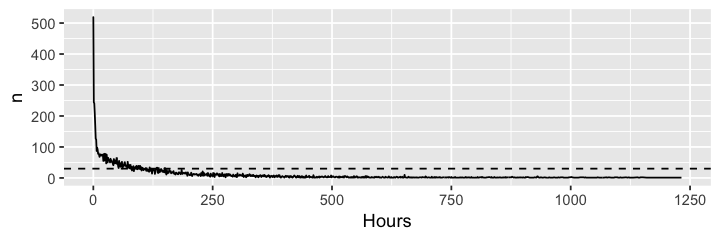

In [172]:
# Create a dataframe for plotting
nslhd_enctrs %>%
#   filter(Status == "STEMI") %>%
  join_forms_bp(form_data.rds) %>%
  select(Gender, journey_key, encntr_key, Label, BP, BP_dttm) %>%
  group_by(journey_key, Label) %>%
  mutate(
#     Test = seq(1, length(Label)),
    Hours = as.integer(round((BP_dttm - min(BP_dttm))/3600)),
    Mean = mean(BP),
    L1 = abs(BP - mean(BP))
  ) %>%
  ungroup() %>%
  group_by(Label, Hours) %>%
  summarise(
    mean_L1 = mean(L1),
    sd_L1 = sd(L1),
    n = n()
  ) -> df

options(repr.plot.width=6, repr.plot.height=2)

# Plot the number of episodes against the number of tests. 
df %>%
  ggplot(aes(x = Hours, y = n)) +
    geom_line() +
    geom_hline(aes(yintercept = 30), linetype = 2)

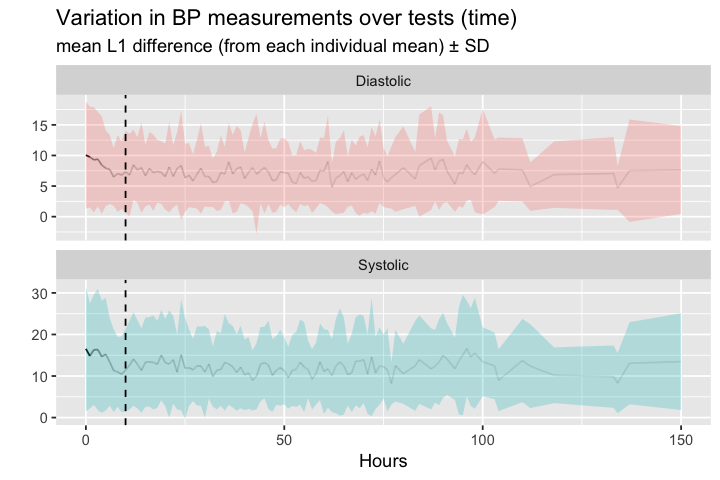

In [176]:
options(repr.plot.width=6, repr.plot.height=4)

# Plot the change in variation in BP test results over time
df %>%
  filter(n > 30 & !is.na(mean_L1)) %>% 
  ggplot(aes(x = Hours, y = mean_L1, group = Label)) +
    geom_line(aes(alpha = n)) +
    geom_ribbon(
      aes(ymin = mean_L1 - sd_L1, ymax = mean_L1 + sd_L1, fill = Label),
      alpha = 0.25) +
    geom_vline(aes(xintercept = 10), linetype = 2) +
    facet_wrap(~Label, ncol = 1, scales = 'free_y') +
    labs(
      title = "Variation in BP measurements over tests (time)",
      subtitle = "mean L1 difference (from each individual mean) ± SD",
      y = "") +
    theme(legend.position = "none")

Blood pressure measurements tend to stablise in the first ten hours after time 0 (first BP measurement)

## Hyperlipidemia
Hyperlipidemia is normally defined by abnormal cholesterol tests indicating:
- Cholesterol (>5.5mmol/L)
- Triglycerides (>2.0mmol/L) 
- LDL (>2,0mmol/L) 
- HDL (<1.0mmol/L)

(see pathology table)  


However, as with hypertension, test results in an acute care setting may not be a reliable indicator of baseline levels, and well-managed patients may not be revealed by this criteria. We need to check:
1. ICD10 codes (`E78`)
2. Recorded diagnoses in past medical history (ED notes)
3. Progress notes
4. Medications for hyperlipidemia
5. Cholesterol results (pathology)

### 1. ICD10 codes

In [61]:
join_icd10_lipids <- function(stemi_input, icd10_input) {
      
  diagnosis <- icd10_input %>%
    select(encntr_key, d_present_on_admit_disp, 
           display_identifier, source_string)
    
  stemi_input %>%
    left_join(diagnosis, by = "encntr_key") %>% 
    group_by(journey_key) %>%
    mutate(
    # Define diabetes pre-existing or new conditions
    lipids_icd10 = case_when(
      any(str_detect(display_identifier, "E78"))                   ~ "Present",
      all(is.na(source_string))                                    ~ "Missing",
      TRUE                                                         ~ "Absent"
      )
    ) %>% 
    select(-d_present_on_admit_disp, -display_identifier, -source_string) %>%
    distinct() %>%
    ungroup() -> out_df

  return(out_df)    
}

nslhd_enctrs %>%
  join_icd10_lipids(diagnosis_icd10.rds) %>%
  select(Status, Gender, journey_key, lipids_icd10) %>%
  distinct() -> nslhd_journeys_lipids_icd10

In [63]:
nslhd_journeys_lipids_icd10 %>%
  filter(Status == "STEMI") %>%
  mutate(lipids = fct_relevel(lipids_icd10, "Present")) %>%
  count(Gender, lipids) %>%
  spread(lipids, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hyperlipedemia = Gender) %>%
  kable(caption = "Source: ICD10") %>% 
  as.character() %>% display_html()

Hyperlipedemia,Present,Absent,Total,%Missing,%Present,%Error
Female,1,25,26,0,3.8,3.7
Male,6,71,77,0,7.8,3.1
Total,7,96,103,0,6.8,2.5


Hyperlipidemia by **ICD10 codes** is **~7 percent**, which is six times lower than CONCORDANCE at ~43 percent (42.8 and 43.8 percent in men and women, respectively) and Vernon et al 2017 (41 percent).

### 2. ED notes

In [66]:
join_notes_lipid <- function(stemi_input, notes_input) {
# PARAMETERS
# stemi_input: A dataframe with journey_key, encntr_key
# notes_input: A dataframe with encntr_key, response, response_type 
# RETURNS
# a dataframe with added column "notes_lipid"
    
    notes_input %>%
      select(encntr_key, note_value) %>%
      as_tibble() -> notes_table
    
    source("../src/CLACK/R/CLACK.R")

    stemi_input %>%
      left_join(notes_table, by = "encntr_key") %>%
      group_by(journey_key) %>%
      mutate(noted = any(!is.na(note_value))) %>%
      ungroup() %>%
      Classify_Text("note_value", "../src/dyslipidemia.json") %>%
      group_by(journey_key) %>%
      mutate(
        lipid_noted = case_when(
          any(CLASSIFICATION == "high") ~ "Present",
          all(!noted)                   ~ "Missing",
          TRUE                          ~ "Absent"
          )
        ) %>%
      select(
        -noted, -note_value, -CLASSIFICATION, -CLASSIFICATION_REASON
        ) %>%
      ungroup() %>%
      distinct() -> out_df
    
    return(out_df)
}

nslhd_enctrs %>%
  join_notes_lipid(notes_ED.rds) %>%
  select(Status, Gender, journey_key, lipid_noted) %>%
  distinct() -> nslhd_journeys_lipid_notes

In [67]:
nslhd_journeys_lipid_notes %>%
  filter(Status == "STEMI") %>%
  mutate(lipids = fct_relevel(lipid_noted, "Present")) %>%
  count(Gender, lipids) %>%
  spread(lipids, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hyperlipedemia = Gender) %>%
  kable(caption = "Source: ED notes") %>% 
  as.character() %>% display_html()

Hyperlipedemia,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,4,12,10,26,38.5,25.0,10.8
Male,8,41,28,77,36.4,16.3,5.3
Total,12,53,38,103,36.9,18.5,4.8


According to the **ED notes**, the prevalence of hyperlipidemia in STEMI is **~18 percent** overall, with the highest rate in female STEMIs. This is approximately half the rate reported in CONCORDANCE and Vernon et al 2017.

### 3. Progress notes
To be done

### 4. Medications

In [69]:
join_meds_lipid <- function(stemi_input, medicine_input) {
# PARAMETERS
# stemi_input: A dataframe with journey_key, encntr_key
# medicine_input: A dataframe with encntr_key, medication_name and groups
# RETURNS
# a dataframe with added column "medications_lipid"
  
    source("../src/journeyr.r")
    
    stemi_input %>%
      mark_journeys_with_discharge_meds(medicine_input) %>% # from journeyr.r
      mutate(has_meds = final_groups != "NULL") %>%         # from journeyr.r
      select(journey_key, has_meds) -> episodes_with_medicines
    
    medicine_input %>%
      filter(purrr::map_lgl(groups, ~any(stringr::str_detect(.x, 
        "Statin|lipid"
        )))) %>%
      select(encntr_key, medication_name) -> dyslipidemia_meds
    
    stemi_input %>%
      left_join(dyslipidemia_meds, by = c("encntr_key")) %>%
      left_join(episodes_with_medicines, by = c("journey_key")) %>%
      group_by(journey_key) %>%
      mutate(
        lipid_meds = case_when(
          any(!is.na(medication_name)) ~ "Present",
          !has_meds ~ "Missing",
          TRUE ~ "Absent"
          )
        ) %>%
      select(-medication_name, -has_meds) %>%
      ungroup() %>%
      distinct() -> out_df
    
    return(out_df)
}

nslhd_enctrs %>%
  join_meds_lipid(meds_spread.rds) %>%
  select(Status, Gender, journey_key, lipid_meds) %>%
  distinct() -> nslhd_journeys_lipid_meds

In [70]:
nslhd_journeys_lipid_meds %>%
  filter(Status == "STEMI") %>%
  mutate(lipids = fct_relevel(lipid_meds, "Present")) %>%
  count(Gender, lipids) %>%
  spread(lipids, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hyperlipedemia = Gender) %>%
  kable(caption = "Source: Medications") %>% 
  as.character() %>% display_html()

Hyperlipedemia,Present,Absent,Total,%Missing,%Present,%Error
Female,19,7,26,0,73.1,8.7
Male,50,27,77,0,64.9,5.4
Total,69,34,103,0,67.0,4.6


According to **medication** sources, the prevalence of hyperlipidemia is **67 percent** in STEMI, which is higher than CONCORDANCE (~43 percent) and Vernon *et al* (41 percent). 

### 5. Cholesteral results

In [76]:
join_pathology_lipid <- function(stemi_input, pathology_input) {
# PARAMETERS
# stemi_input: A dataframe with journey_key, encntr_key
# pathology_input: A dataframe with encntr_key, result_tag, result_display
# & normal_high, normal_low, result_start_dttm
# RETURNS
# a dataframe with added columns "RESULT_DISPLAY", "RESULT_TAG", "abnormal"
  
  lipid_tests <- c("Cholesterol", "LDL Cholesterol", "HDL Cholesterol", "Triglycerides")
  
  pathology_input %>%
    filter(result_tag != "Error") %>%
    # select only our biochem tests of interest
    filter(result_display %in% lipid_tests) %>%
    mutate_at(vars(result_tag, normal_low, normal_high), extract_numeric) %>%
    select(
      encntr_key, result_start_dttm, result_display, result_tag, normal_low, normal_high
    ) %>%
    mutate(
      normal_low = replace_na(normal_low, 0),
      normal_high = ifelse(is.na(normal_high), Inf, normal_high)
    ) -> lipid_results
  
  suppressWarnings(
    
  stemi_input %>%
    left_join(lipid_results, by = "encntr_key") %>%
    group_by(journey_key, result_display) %>%
    mutate(
      first_test = result_start_dttm == min(result_start_dttm, na.rm = TRUE),
      test_abnormal = case_when(
        result_display != "HDL Cholesterol" & result_tag > normal_high ~ TRUE,
        result_display == "HDL Cholesterol" & result_tag < normal_low ~ TRUE,
        is.na(result_tag) ~ NA,
        TRUE ~ FALSE)
      ) %>% 
    filter(first_test | is.na(first_test)) %>% # Keep missing records to count
    select(-result_start_dttm, -normal_low, -normal_high, -first_test) %>%
    ungroup()
    ) -> out_df
}

nslhd_enctrs %>%
  select(Status, Gender, journey_key, encntr_key) %>%
  join_pathology_lipid(pathology_result.rds) %>%
  group_by(journey_key, Status, Gender) %>%
  summarise(
    lipid_abnormal = case_when(
      any(test_abnormal, na.rm = TRUE) ~ "Present",
      all(is.na(test_abnormal))        ~ "Missing",
      TRUE                             ~ "Absent"
    )
  ) %>%
  ungroup() -> nslhd_journeys_lipid_abnorm

In [82]:
nslhd_journeys_lipid_abnorm %>%
  filter(Status == "STEMI") %>%
  mutate(lipids = fct_relevel(lipid_abnormal, "Present")) %>%
  count(Gender, lipids) %>%
  spread(lipids, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = round(Missing/Total*100, 1),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hyperlipedemia = Gender) %>%
  kable(caption = "Source: Cholesterol (pathology)") %>% 
  as.character() %>% display_html()

Hyperlipedemia,Present,Absent,Missing,Total,%Missing,%Present,%Error
Female,7,10,9,26,34.6,41.2,11.9
Male,34,19,24,77,31.2,64.2,6.6
Total,41,29,33,103,32.0,58.6,5.9


According to **pathology** sources, the prevalence of hyperlipidemia is **~59 percent** in STEMI, which is higher than CONCORDANCE (~43 percent) and Vernon et al 2017 (41 percent). 

### Hyperlipidemia by primary sources

In [81]:
# Combining all primary sources
nslhd_journeys_lipid_abnorm %>%
  left_join(nslhd_journeys_lipid_meds) %>%
  left_join(nslhd_journeys_lipid_notes) %>%
  mutate(
    hyperlipidemia = case_when(
      lipid_abnormal == "Present" | 
      lipid_meds     == "Present" | 
      lipid_noted    == "Present" ~ "Present",
      lipid_abnormal == "Missing" & 
      lipid_meds     == "Missing" & 
      lipid_noted    == "Missing" ~ "Missing",
      TRUE                        ~ "Absent"
    )
  ) %>%
  select(Status, Gender, journey_key, hyperlipidemia) %>%
  distinct() %>%
  filter(Status == "STEMI") %>%
  mutate(hyperlipidemia = fct_relevel(hyperlipidemia, "Present")) %>%
  count(Gender, hyperlipidemia) %>%
  spread(hyperlipidemia, n) %>% 
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = Total - (Present + Absent),
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(Hyperlipidemia = Gender) %>%
  kable(caption = "Source: All primary") %>% 
  as.character() %>% display_html()

Joining, by = c("journey_key", "Status", "Gender")
Joining, by = c("journey_key", "Status", "Gender")


Hyperlipidemia,Present,Absent,Total,%Missing,%Present,%Error
Female,19,7,26,0,73.1,8.7
Male,56,21,77,0,72.7,5.1
Total,75,28,103,0,72.8,4.4


The prevalence of hyperlipidemia is **~73 percent** in STEMI, which is almost twice as high as CONCORDANCE (~43 percent) and Vernon *et al* (41 percent).

## Smoking
Smoking is indicated in the social history table. It is also recorded in ED notes as free text under risk factors, personal and social history.

### 1. ED notes

In [3]:
join_history_smoke <- function(stemi_input, history_input) {
# PARAMETERS
# stemi_input: A dataframe with person_key
# history_input: A dataframe with person_key, response, response_type 
# RETURNS
# a dataframe with one added column "history_smoke"
  
  smoke_strings = c("Smoker", "Non-smoker", "Ex-smoker")
    
  history_input %>%
    mutate(response = as.character(response)) %>%
    filter(response_type == "ALPHA", response %in% smoke_strings) %>%
    select(person_key, response) %>%
    distinct() -> smoke.tb

  stemi_input %>%
    left_join(smoke.tb, by = "person_key") %>%
    mutate(
      history_smoke = recode(
        response,
        "Ex-smoker" = "Ex", 
        "Non-smoker" = "Non", 
        .missing = "Missing")
      ) %>%
    select(-response) -> out_df
    
  return(out_df)
}

nslhd_enctrs %>%
  select(Status, Gender, journey_key, person_key) %>%
  distinct() %>%
  join_history_smoke(patient_history.rds) %>%
  select(Status, Gender, journey_key, history_smoke) %>%
  distinct() %>% 
  count(Status, Gender, history_smoke) %>%
  spread(history_smoke, n, fill = 0) %>%
  mutate(
    Total = Smoker + Ex + Non + Missing,
    "%Missing" = round(Missing/Total*100, 1),
    "%Smoker"  = round(Smoker/(Smoker + Ex + Non)*100, 1)
    ) %>%
  select(Status, Gender, Total, Smoker, Ex, Non, Missing, everything())

Status,Gender,Total,Smoker,Ex,Non,Missing,%Missing,%Smoker
STEMI,Female,26,0,1,1,24,92.3,0.0
STEMI,Male,77,0,1,7,69,89.6,0.0
NSTEMI,Female,113,3,2,7,101,89.4,25.0
NSTEMI,Male,149,5,12,11,121,81.2,17.9


In [4]:
join_notes_smoker <- function(stemi_input, notes_input) {
# PARAMETERS
# stemi_input: A dataframe with JOURNEY_KEY, ENCNTR_KEY
# notes_input: A dataframe with ENCNTR_KEY, note_value 
# RETURNS
# a dataframe with one added column "notes_smoker"
      
  notes_input %>%
    select(encntr_key, note_value) %>%
    as_tibble() -> notes_table
    
  source("../src/CLACK/R/CLACK.R")

  stemi_input %>%
    left_join(notes_table, by = "encntr_key") %>%
    group_by(journey_key) %>%
    mutate(noted = any(!is.na(note_value))) %>%
    ungroup() %>%
    Classify_Text("note_value", "../src/smokers.json") %>%
    group_by(journey_key) %>%
    mutate(
      notes_smoker = case_when(
        any(str_detect(CLASSIFICATION_REASON, "ex-smoker"))  ~ "Ex",
        any(str_detect(CLASSIFICATION_REASON, "non-smoker")) ~ "Non",
        any(str_detect(CLASSIFICATION_REASON, "smoker"))     ~ "Smoker",
        all(!noted)                                          ~ "Missing",
        TRUE                                                 ~ "Non"
        )
      ) %>%
    select(
      -noted, -note_value, -CLASSIFICATION, -CLASSIFICATION_REASON
      ) %>%
    ungroup() %>%
    distinct() -> out_df
    
  return(out_df)
}

nslhd_enctrs %>%
  select(Status, Gender, journey_key, encntr_key) %>%
  distinct() %>%
  join_notes_smoker(notes_ED.rds) %>%
  select(Status, Gender, journey_key, notes_smoker) %>%
  distinct() %>% 
  count(Status, Gender, notes_smoker) %>%
  spread(notes_smoker, n, fill = 0) %>%
  mutate(
    Total = Smoker + Non + Missing + Ex,
    "%Missing" = round(Missing/Total*100, 1),
    "%Smoker"  = round(Smoker/(Smoker + Non + Ex)*100, 1)
    ) %>%
  select(Status, Gender, Total, Smoker, Ex, Non, Missing, everything())

Status,Gender,Total,Smoker,Ex,Non,Missing,%Missing,%Smoker
STEMI,Female,26,1,3,12,10,38.5,6.2
STEMI,Male,77,7,2,40,28,36.4,14.3
NSTEMI,Female,113,6,5,88,14,12.4,6.1
NSTEMI,Male,149,6,21,89,33,22.1,5.2


In [5]:
nslhd_enctrs %>%
  select(Status, Gender, journey_key, encntr_key, person_key) %>%
  distinct() %>%
  join_history_smoke(patient_history.rds) %>%
  join_notes_smoker(notes_ED.rds) -> nslhd_smoker_journeys

#### Results
We join the smoking table and the journeys table and count the number in each group

In [6]:
nslhd_smoker_journeys %>%
  mutate(Smoker = case_when(
    history_smoke == "Smoker" | notes_smoker == "Smoker" ~ "Smoker",
    history_smoke == "Ex"     | notes_smoker == "Ex"     ~ "Ex",
    notes_smoker ==  "Missing"                           ~ history_smoke,
    history_smoke == "Missing"                           ~ notes_smoker,
    TRUE                                                 ~ "Non")
    ) %>% 
  select(Status, Gender, journey_key, Smoker) %>%
  distinct() %>%
  count(Status, Gender, Smoker) %>%
  spread(Smoker, n, fill = 0) %>%
  mutate(
    Total = Smoker + Ex + Non + Missing,
    "%Missing" = round(Missing/Total*100, 1),
    "%Smoker"  = round(Smoker/(Smoker + Ex + Non)*100, 1)
    ) %>%
  select(Status, Gender, Total, Smoker, Ex, Non, Missing, everything())

Status,Gender,Total,Smoker,Ex,Non,Missing,%Missing,%Smoker
STEMI,Female,26,1,4,12,9,34.6,5.9
STEMI,Male,77,7,3,42,25,32.5,13.5
NSTEMI,Female,113,8,7,84,14,12.4,8.1
NSTEMI,Male,149,9,30,86,24,16.1,7.2


#### Conclusions
Male STEMIs have the highest smoking risk. Our estimate of current smoking prevalence among STEMI is much lower than CONCORDANCE (~40 percent) or Vernon et al (28 percent). However, approximately **~35 percent** of STEMI episodes are missing smoking data (ED notes or social history). 

## Obesity
Obesity is normally defined as a BMI value:
- "Healthy" < 25 m/kg^2
- "Overweight" between 25 and 30 m/kg^2
- "Obese" > 30 m/kg^2

We can check:
1. ICD10 codes (`E66|U78.1`)
2. BMI records (Forms table)

### 1. ICD10 codes

In [73]:
join_icd10_obesity <- function(stemi_input, icd10_input) {
      
  diagnosis <- icd10_input %>%
    select(encntr_key, d_present_on_admit_disp, 
           display_identifier, source_string)
    
    
  stemi_input %>%
    left_join(diagnosis, by = "encntr_key") %>% 
    group_by(journey_key) %>%
    mutate(
    # Define diabetes pre-existing or new conditions
    obesity_icd10 = case_when(
      any(str_detect(display_identifier, "E66|U78.1")) ~ "Present",
      all(is.na(source_string))                        ~ "Missing",
      TRUE                                             ~ "Absent"
      )
    ) %>% 
    select(-d_present_on_admit_disp, -display_identifier, -source_string) %>%
    distinct() %>%
    ungroup() -> out_df

  return(out_df)    
}

nslhd_enctrs %>%
  join_icd10_obesity(diagnosis_icd10.rds) %>%
  select(Status, Gender, journey_key, obesity_icd10) %>%
  distinct() -> nslhd_journeys_obesity_icd10

Status,Gender,journey_key,obesity_icd10
NSTEMI,Male,305443,Present
STEMI,Male,218722,Absent
STEMI,Male,309949,Absent
STEMI,Female,134204,Absent
STEMI,Female,312530,Absent
NSTEMI,Male,83931,Present


In [75]:
cat("Presence of obesity by ICD10 codes")
nslhd_journeys_obesity_icd10 %>%
  filter(Status == "STEMI") %>%
  mutate(obesity = fct_relevel(obesity_icd10, "Present")) %>%
  count(Gender, obesity) %>%
  spread(obesity, n, fill = 0) %>%
  bind_rows(summarise_all(., funs(if(is.numeric(.)) sum(.) else "Total"))) %>%
  mutate(
    Total = rowSums(select_if(., is.numeric)),
    `%Missing` = 0,
    `%Present` = round(Present/(Present + Absent)*100, 1),
    `%Error` = round(sqrt(`%Present`*(100-`%Present`) / (Present + Absent)),1)
  ) %>%
  rename(STEMI = Gender)

Presence of obesity by ICD10 codes

STEMI,Present,Absent,Total,%Missing,%Present,%Error
Female,3,23,26,0,11.5,6.3
Male,16,61,77,0,20.8,4.6
Total,19,84,103,0,18.4,3.8


### 2. BMI records
The [risk factors table on confluence](https://ctdshub.atlassian.net/wiki/spaces/HEAL/pages/767492185/Characteristics+and+Risk+Factors+in+the+EMR) mentions that BMI can be found in the `Height and Weight` section. But we will select all the BMI data, regardless of section. (Most of the BMI values come from the `Waterlow Assessment` section, which represents about twice as many values as the Height and Weight section) 

Since multiple BMI values are returned from different sections, we will reduce the redundancy and take the average BMI per encounter.

In [7]:
join_forms_bmi <- function(stemi_input, forms_input){
# PARAMETERS
# stemi_input: A dataframe with JOURNEY_KEY, ENCNTR_KEY
# forms_input: A dataframe with ENCNTR_KEY, SECTION_NAME, LABEL
# & CHARTED_VALUE
# RETURNS a dataframe with added column "forms_bmi_mean"  

  # Select all the BMI data
  forms_input %>%
    select(encntr_key, section_name, label, charted_value) %>%
    filter(label == "Body Mass Index") %>%
    mutate(forms_bmi = extract_numeric(charted_value)) %>%
    select(-charted_value, -label) %>%
    distinct() -> bmi.tb # 25371
    
  # Calculate BMI per encounter
  bmi.tb %>%
    select(encntr_key, forms_bmi) %>%
    group_by(encntr_key) %>%
    summarise(forms_bmi_mean = mean(forms_bmi, na.rm = TRUE)) %>%
    filter(!is.na(forms_bmi_mean)) -> bmi.encntr 
    
  # Join and count BMI results
  stemi_input %>%
    left_join(bmi.encntr, by = "encntr_key") -> out_df

  return(out_df)
}

In [8]:
nslhd_enctrs %>%
  join_forms_bmi(form_data.rds) %>%
  select(Status, Gender, journey_key, forms_bmi_mean) %>%
  distinct() %>% 
  group_by(Status, Gender, journey_key) %>%
  summarise(
    max_bmi = max(forms_bmi_mean, na.rm = TRUE),
    min_bmi = min(forms_bmi_mean, na.rm = TRUE),
    range_bmi = abs(max_bmi - min_bmi),
    missing = all(is.na(forms_bmi_mean))
    ) %>%
  mutate(max_bmi = ifelse(max_bmi > -Inf & max_bmi < Inf, max_bmi, NA)) %>%
  ungroup() %>%
  select(Status, Gender, max_bmi) %>%
  mutate(
    bmi_class = case_when(
      max_bmi < 25                  ~ "Healthy",
      max_bmi >= 25 & max_bmi <= 30 ~ "Overweight",
      max_bmi > 30                  ~ "Obese",
      is.na(max_bmi)                ~ "Missing"
      ),
    bmi_class = fct_relevel(bmi_class, "Healthy", "Overweight", "Obese"),
    ) %>%
  count(Status, Gender, bmi_class) %>%
  spread(bmi_class, n) %>%
  mutate(
    Total = Healthy + Overweight + Obese + Missing,
    "%Missing" = round(Missing/Total*100, 1),
    "%Obese"  = round(Obese/(Healthy + Overweight + Obese)*100, 1)
  )

Status,Gender,Healthy,Overweight,Obese,Missing,Total,%Missing,%Obese
STEMI,Female,8,4,1,13,26,50.0,7.7
STEMI,Male,10,14,17,36,77,46.8,41.5
NSTEMI,Female,31,14,12,56,113,49.6,21.1
NSTEMI,Male,19,32,16,82,149,55.0,23.9


#### Conclusions
Male STEMIs have the highest obesity risk. Obesity is not recorded in CONCORDANCE or Vernon et al so we can't compare our results here. The missingness in BMI measurements is **~50 percent**, when all possible sources of BMI values are included. (We can expect this to be substantially reduced if we only include BMI values from the `Height and Weight` section)  

*Measurement error* is another concern. When BMI is recorded in multiple sections we sometimes find a range of BMI values are be recorded for a single episode (we have eliminated any range present in a single encounter). In approximately ~4 percent of episodes, the range of BMI values in a single episode of care can be ~$3 \ kg/m^2$, which is unlikely.

**To be done**
1. Check BMI range against date range
2. Collate height and weight values to reduce missingness
3. Compare first BMI vs max BMI